# Advanced Time-Series Analysis and Deep Learning: Homework #3

## Motif Discovery

### Mathematical Formulation

(a): In time-series data, motifs are pairs of individual time series, or subsequences of longer time series, which are very similar to each other. A motif can tell us about recurring patterns within time series data!

(b): 
Let me formulate this mathematically. 

Case 1: Time Series Motif

I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

A Time Series Database $D$ is an unordered set of m time series possibly of different lengths.

The Time Series Motif of $D$ is the unordered pair of time series ${T_i, T_j}$ in D which is the most similar among all possible pairs

Essentially, $\forall a,b,i,j$, 

${T_i, T_j}$ is the motif iff $dist(T_i, T_j) ≤ dist(T_a, T_b)$, $i \neq j$ and $a \neq b$.


Case 2: Subsequence Motif

We can also calculate a Subsequence Motif. Given a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 
Let's say we have two subsequences $T_c$ and $T_d$

Essentially, $\forall c,d,i,j$, 

${T_c, T_d}$ is the subsequence motif iff $dist(T_c, T_d) ≤ dist(T_i, T_j)$, $i \neq j$ and $a \neq b$.



In [186]:
import numpy as np
### First Generate sine curve
n = 101

# t => [0, 10 * pi]
t = np.linspace(start = 0, stop = 10 * np.pi, num = n, endpoint = True)
x = np.sin(t)

#Generate Noise
noise = np.random.normal(loc = 0, scale = 2, size = (n,))

#Embed Motif
timestep = 10

for i in range(1, n // timestep, 4):
    pivot = timestep * i
    time_slice = t[pivot - 6 : pivot + 6]
    noise[pivot - 6 : pivot + 6] = np.cos(time_slice)
    print(np.rad2deg(time_slice) % 360, i)

x_adjusted = x + noise

[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 1
[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 5
[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 9


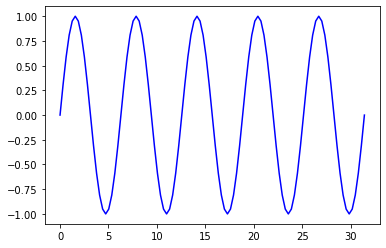

In [187]:
import matplotlib.pyplot as plt
plt.plot(t, x, label='sin(x)', color='blue', linestyle='-')

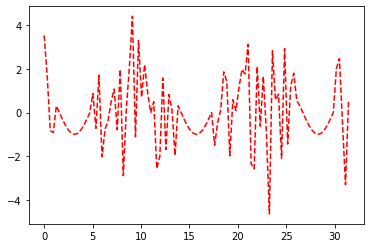

In [188]:
plt.plot(t, noise, label='noise', color='red', linestyle='--')


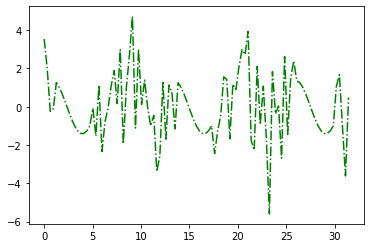

In [189]:
plt.plot(t, x_adjusted, color='green', linestyle='-.')  

## Matrix Profile

General Concept: 
In time series analysis, a matrix profile is used to find anomalies and trends within time series data. 

Mathematical Formulation: 

1. I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

2. A subsequence $T_{i,m}$ of a T is a continuous subset of the values from T of length m starting from position i. $T_{i,m} = t_i, t_{i+1} ,…, t_{i+m-1}$, where $1 \leq i \leq n-m+1$.

3. A distance profile D is a vector of the Euclidean distances between a given query and each subsequence in an all-subsequences set

4. An all-subsequences set A of a time series T is an ordered set of all possible subsequences of T obtained by sliding a window of length m across T: 

$A ={T_{1,m},, T_{2,m},…, T_{n-m+1,m}}$, where m is a user-defined subsequence length. We use A[i] to denote $T_{i,m}$.

5. 1NN-join function: given two all-subsequences sets A and B and two subsequences A[i] and B[j], a 1NN-join function $\theta_{1nn}$ (A[i], B[j]) is a Boolean
function which returns “true” only if B[j] is the nearest neighbor of A[i] in the set B.

6. Similarity join set: given all-subsequences sets A and B, a similarity join set $J_{AB}$ of A and B is a set containing pairs of each subsequence in A with its nearest neighbor in B: $J_{AB}={〈 A[i], B[j] 〉| θ_{1nn} (A[i], B[j])}$ . We denote this formally as $J_{AB} = A \bowtie_{\theta_{1nn}} B$.

7. A matrix profile (or just profile) $P_{AB}$ is a vector of the Euclidean distances between each pair in $J_{AB}$

In [190]:
def generate_subsequences_set(T, M):
    N = len(T) - M + 1
    indices = np.arange(M) + np.arange(N)[:, np.newaxis]
    return T[indices]

T = np.array([-1, 1, 3, -9, 2, 6, 3, 4, 5, -10, -11, 2])
T = x_adjusted
M = 12

A = generate_subsequences_set(T, M)

def generate_matrix_profile(A, M):
    N = len(A)
    
    exclusion = np.ceil(M / 2)
    distances = np.zeros(shape = (N,))
    indices = np.zeros(shape = (N,))
    
    for i in range(N):
        bound1 = max(0, i - exclusion)
        bound2 = min(i + exclusion, N - 1)
        
        min_distance = float('inf')
        min_index = None
        
        for j in range(N):
            if bound1 <= j and j <= bound2: continue 
            d = np.linalg.norm(A[i] - A[j])
            if d < min_distance:
                min_distance = d
                min_index = j
        
        indices[i] = min_index
        distances[i] = min_distance
    
    return distances, indices

generate_matrix_profile(A, M)

(array([2.97515256e+00, 1.64741810e+00, 1.40693542e+00, 1.04989806e+00,
        3.13232462e-15, 1.14325449e+00, 1.63254158e+00, 2.26076904e+00,
        3.20418684e+00, 3.42041532e+00, 3.19607986e+00, 2.99149886e+00,
        2.84310724e+00, 3.30049528e+00, 3.73662104e+00, 4.69236452e+00,
        4.80444368e+00, 4.63085689e+00, 5.03868980e+00, 6.58154191e+00,
        6.94562272e+00, 6.27127408e+00, 6.09115147e+00, 5.91916999e+00,
        5.63279629e+00, 4.89304859e+00, 5.32173346e+00, 5.43233602e+00,
        5.70242463e+00, 5.59061603e+00, 5.05106645e+00, 4.73890716e+00,
        4.11096610e+00, 4.51911286e+00, 4.16534552e+00, 4.19317730e+00,
        4.73915490e+00, 4.77981061e+00, 3.34410498e+00, 3.34304246e+00,
        3.05793156e+00, 1.64741810e+00, 1.40693542e+00, 1.04989806e+00,
        3.13232462e-15, 1.63254158e+00, 2.11793460e+00, 2.25161639e+00,
        2.34576427e+00, 2.60908503e+00, 2.36523191e+00, 3.73662104e+00,
        4.09589441e+00, 4.19317730e+00, 4.33704645e+00, 5.034531

### Matrix Profile Algorithm Implementation

In [191]:
distance_profile, index_profile = generate_matrix_profile(A, M)

#To find a motif, we need to find a minimum value in the distance profile 
ix = np.where(distance_profile == np.min(distance_profile))[0]

index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[ 4 44]
[44.  4.]
[3.13232462e-15 3.13232462e-15]


### Optimized Matrix Profile Algorithm Implementation

In [212]:
### Optimize Matrix Profile Algorithm using FFT Approach outlined in paper
def sliding_dot_product(Q, T):
    n, m = len(T), len(Q)
    Ta = np.append(T, np.zeros(n))
    Qr = np.flip(Q)
    Qra = np.append(Qr, np.zeros(2 * n - m))
    Qraf, Taf = np.fft.fft(Qra), np.fft.fft(Ta)
    QT = np.fft.ifft(Qraf * Taf)
    return QT

def compute_mean_std(Q, T):
    uq = np.mean(Q)
    stdev_Q = np.std(Q)
    n,m = len(T), len(Q)
    
    M = np.zeros(shape = (n - m + 1,))
    Sigma = np.zeros(shape = (n - m + 1,))
    window = T[0:m]
    
    M[0] = np.mean(window)
    Sigma[0] = np.std(window)
    
    total = np.sum(window)
    total_elements_squared = np.sum(window ** 2)
    
    window_start = 0
    window_end = m - 1
    
    for index in range(1, n - m + 1):
        total = total - T[window_start] + T[window_end + 1]
        total_elements_squared = total_elements_squared - (T[window_start] ** 2) + (T[window_end + 1] ** 2)
        
        M[index] = total / m
        Sigma[index] = np.sqrt((total_elements_squared - (2 * M[index] * total) + ((M[index] ** 2) * m)) / m)
        
        window_start += 1
        window_end += 1
    
    return uq, stdev_Q, M, Sigma

def calculate_distance_profile(Q, T, QT, uq, stdev_Q, M, Sigma):
    n,m = len(T), len(Q)
    QT = QT[m - 1: n]
    D = np.sqrt(2 * m * (1 - ((QT - m * uq * M) / (m * stdev_Q * Sigma))))
    return D

def MASS(Q, T):
    QT = sliding_dot_product(Q, T)
    uq, stdev_Q, M, Sigma = compute_mean_std(Q, T)
    D = calculate_distance_profile(Q, T, QT, uq, stdev_Q, M, Sigma)
    return D
    
T = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
Q = np.array([2,3,4])

MASS(Q, T)

array([1.78619547e-08+1.10947997e-07j, 1.13654609e-07+5.99290983e-08j,
       7.43863613e-08+8.28589064e-08j, 9.45492244e-08+1.01350005e-07j,
       7.47689500e-08+8.32025451e-08j, 2.09552548e-07+5.11074752e-08j,
       1.25569386e-08-3.85997971e-08j, 8.52499328e-08-9.27352073e-08j])

## Discord Identification

1. Time series discords are subsequences of longer time series that are maximally different to the rest of the time series subsequences. 

Mathematical Formulation: 

- I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

- We can define a subsequence $C$ of length $m$, where $m \leq n$, which is a contiguous slice from $T$. 

$C = [t_p, t_{p + 1}, ...., t_{p+n-1}]$ for $1 \leq p \leq m - n + 1$

- Given two subsequences, $C$ and $B$, we can define a function $D$ such that $D(B, C) = R$ where $R$ is a non-negative number and represents the distance between $B$ and $C$. 

- Non-Self Match: : Given a time series T, containing a subsequence C of length n beginning at position p and a matching subsequence B beginning at q, we say that B is a non-self match to C at distance of $D(B, C)$ if $|p - q| \geq n$

- Time Series Discord: Given a time series T, the subsequence A of length n beginning at position $i$ is said to be the discord of T if A has the largest distance to its nearest non-self match. $\forall C \in T$, let $M_C$ be any arbitrary non-self match of $C$ and $M_A$ be any arbitrary non-self match of $A$. We want the following to be true: 

$min(D(A, M_D)) > min(D(C, M_C))$


### Implementation of Discord Identification Algorithm

In [192]:
distance_profile, index_profile = generate_matrix_profile(A, M)

#To find a motif, we need to find a minimum value in the distance profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]

index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[65]
[29.]
[7.51478717]


### HOT SAX

In [193]:
#Define Gaussian Distribution
mean = np.mean(T)
var = np.var(T)
stdev = np.sqrt(var)

# mean - 2 * stdev [A], mean - stdev [B], mean [C], mean + stdev [D], mean + 2 * stdev [E]
def discretize_window(window):
    u = np.mean(window)
    if u <= mean - 2 * stdev:
        return 'A'
    elif u <= mean - stdev:
        return 'B'
    elif u <= mean:
        return 'C'
    elif u <= mean + stdev:
        return 'D'
    elif u <= mean + 2 * stdev:
        return 'E'
    else:
        return 'F'

def generate_word(T, P):
    return np.apply_along_axis(discretize_window, axis = 1, arr = generate_subsequences_set(T, P)).flatten()


P = 3 #window length to generate SAX encoding
W = generate_word(T, P)

L = M // P #letter subsequence length

#M = 12, hence, we are working with 4 letter subsequences here
A = generate_subsequences_set(W, L)

def edit_distance(W1, W2):
    if len(W2) == 0:
        return len(W1)

    if len(W1) == 0:
        return len(W2)
    
    if W1[0] == W2[0]:
        return edit_distance(W1[1:], W2[1:])
    
    return 1 + min(edit_distance(W1[1:], W2), edit_distance(W1, W2[1:]), edit_distance(W1[1:], W2[1:]))


def generate_SAX_matrix_profile(A, L):
    N = len(A)
    
    exclusion = np.ceil(L / 2)
    distances = np.zeros(shape = (N,))
    indices = np.zeros(shape = (N,))
    
    for i in range(N):
        bound1 = max(0, i - exclusion)
        bound2 = min(i + exclusion, N - 1)
        
        min_distance = float('inf')
        min_index = None
        
        for j in range(N):
            if bound1 <= j and j <= bound2: continue 
            d = edit_distance(A[i], A[j])
            if d < min_distance:
                min_distance = d
                min_index = j
        
        indices[i] = min_index
        distances[i] = min_distance
    
    return distances, indices

print(W)
print(A)

distance_profile, index_profile = generate_SAX_matrix_profile(A, M)
print(distance_profile)
print(index_profile)

['E' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'E' 'E' 'E' 'D' 'D' 'D' 'D' 'C' 'C'
 'B' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'E' 'E' 'E' 'D' 'C' 'C' 'C' 'D' 'C'
 'B' 'B' 'C' 'D' 'C' 'C' 'C' 'D' 'D' 'E' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'C' 'C']
[['E' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'C']
 ['D' 'D' 'C' 'C']
 ['D' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'C']
 ['C' 'C' 'C' 'D']
 ['C' 'C' 'D' 'D']
 ['C' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'E']
 ['D' 'D' 'E' 'E']
 ['D' 'E' 'E' 'E']
 ['E' 'E' 'E' 'D']
 ['E' 'E' 'D' 'D']
 ['E' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D']
 ['D' 'D


['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'D']
['C' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'E']
['D' 'E' 'E']
['E' 'E' 'E']
['E' 'E' 'D']
['E' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'C']
['D' 'C' 'C']
['C' 'C' 'B']
['C' 'B' 'C']
['B' 'C' 'C']
['C' 'C' 'D']
['C' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'C']
['D' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'D']
['C' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'D']
['D' 'D' 'E']
['D' 'E' 'E']
['E' 'E' 'E']
['E' 'E' 'D']
['E' 'D' 'C']
['D' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'D']
['C' 'D' 'C']
['D' 'C' 'B']
['C' 'B' 'B']
['B' 'B' 'C']
['B' 'C' 'D']
['C' 'D' 'C']
['D' 'C' 'C']
['C' 'C' 'C']
['C' 'C' 'D']
['C' 'D' 'D']
['D' 'D' 'E']
['D' 'E' 'D']
['E' 'D' 'D']
['D' 

In [194]:
#To find a motif, we need to find a minimum value in the distance profile 
ix = np.where(distance_profile == np.min(distance_profile))[0]

index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30 31 32 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 66 67 75 76 77 81 82 83 84 85 86 87 88
 89 90 91 92 93 95]
[29. 20. 20. 20. 31. 32. 46. 14. 15. 16. 47. 47. 47. 47.  7.  7.  7. 55.
 37. 38.  1.  1.  1.  1. 60. 61. 62. 63.  0.  1.  4.  5. 18. 19.  1.  1.
  1.  1.  1.  4.  5.  6.  7.  7.  7.  7.  7.  7.  7.  7. 17. 18. 19.  1.
  1. 24. 25. 26. 27.  6. 17.  6. 17. 18.  0.  1.  1.  4.  5.  6.  7.  7.
  7.  7.  7. 17. 18.  5.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


#### Assignment Notes

- 
- 
- 